In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image



In [ ]:
print(os.listdir(r'/content/drive/MyDrive/data'))

['data credit.txt', 'train', 'unknown(test)', 'test']


In [ ]:
folder_benign_train = r'/content/drive/MyDrive/data/train/benign'
folder_malignant_train = r'/content/drive/MyDrive/data/train/malignant'

folder_benign_test = r'/content/drive/MyDrive/data/test/benign'
folder_malignant_test = r'/content/drive/MyDrive/data/test/malignant'

In [ ]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0) # here  training data is present
y_train = np.concatenate((y_benign, y_malignant), axis = 0) # here  corresponding trained data's label is present

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)# here  testing data is present
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)# here  corresponding test data's label is present

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
from glob import glob
from PIL import Image
np.random.seed(20)
from sklearn.metrics import accuracy_score

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras import backend as K
from keras.optimizers import Adam  
from keras.callbacks import ReduceLROnPlateau

In [ ]:
input_shape = (224,224,3)
lr = 1e-5 # learning rate
epochs = 50
batch_size = 32

# set learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=1e-7)

#Coding of VGG Starts from here for deep Feature extration  starts from below

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vvg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# let's make all layers non-trainable

for layers in (vvg.layers):
    layers.trainable = False

In [ ]:
vvg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
feature_extractor = vvg.predict(X_train)


83/83 [==============================] - 22s 128ms/step


In [ ]:
feature_extractor.shape


(2636, 7, 7, 512)

In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features

In [ ]:
X_train_features.shape

(2636, 25088)

In [ ]:
# perform same operation on test dataset
feature_extractor_test = vvg.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test

21/21 [==============================] - 5s 245ms/step


#Coding of SVM Starts from here in Hybrid Learning model

In [ ]:
from sklearn.svm import SVC
mlmodel= SVC(C=10, gamma= 0.0001, kernel='rbf')


In [ ]:
mlmodel.fit(X_train_features, y_train)

SVC(C=10, gamma=0.0001)

In [ ]:
svm_pred = mlmodel.predict(X_test_features)

In [ ]:
import sklearn.metrics as metrics
print('Accuracy of SVM : ', metrics.accuracy_score(y_test, svm_pred)*100)


Accuracy of SVM :  85.45454545454545


In [ ]:
# inversing le transforme to get original labels
# rfc_pred = le.inverse_transform(svm_pred)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Text(0.5, 1.0, 'Hybrid model Preformance (SVM + VGG -16)')

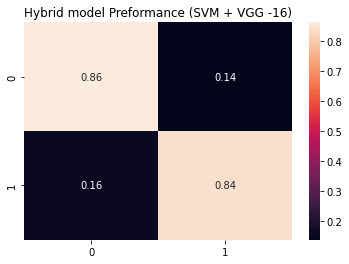

In [ ]:
cm = confusion_matrix(y_test, svm_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('Hybrid model Preformance (SVM + VGG -16)')

In [ ]:
# Classification report
print('Support Vector Machine ')
print(classification_report(y_test, svm_pred))

Support Vector Machine 
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       360
         1.0       0.84      0.84      0.84       300

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660



In [ ]:
# save the model
import joblib

joblib.dump(mlmodel, 'hybrid_model.pkl')

['hybrid_model.pkl']

#Coding of XGBoost Starts from here

In [ ]:
import pickle


In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train_features, y_train)
xgb_pred = model.predict(X_test_features)

In [ ]:
pickle.dump(model, open('hybrid_surya_model.pkl', 'wb'))


In [ ]:
pickled_model = pickle.load(open('hybrid_surya_model.pkl', 'rb'))
pickled_model.predict(X_test_features)

array([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,

In [ ]:
import sklearn.metrics as metrics
print('Accuracy of XGBOOST : ', metrics.accuracy_score(y_test, xgb_pred)*100)


Accuracy of XGBOOST :  86.66666666666667


In [ ]:
# Classification report of XGB
print('Classification report of Hybrid Model (Vgg16 + XG-Boost) ')
print(classification_report(y_test, xgb_pred))

Classification report of Hybrid Model (Vgg16 + XG-Boost) 
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       360
         1.0       0.85      0.87      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



Text(0.5, 1.0, 'Hybrid model Preformance (VGG-16 + XG-Boost)')

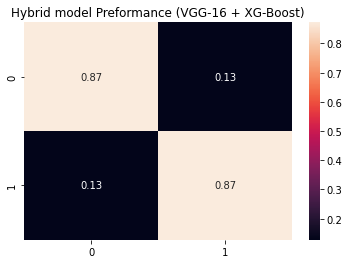

In [ ]:
# Confusion matrix based on XGBOOST
cm = confusion_matrix(y_test, xgb_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('Hybrid model Preformance (VGG-16 + XG-Boost)')

Text(0.5, 1.0, 'Incorrect Prediction Vs True Label of Hybrid Model (Vgg-16 + XGBoost)')

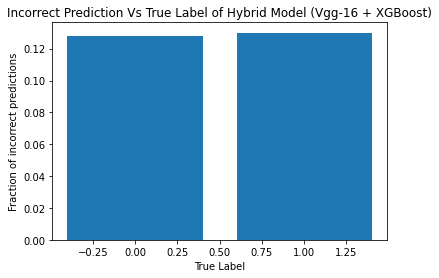

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.title('Incorrect Prediction Vs True Label of Hybrid Model (Vgg-16 + XGBoost)')

#Coding of LGBoost Starts from here

In [ ]:
# Lgiht GBM
import lightgbm as lgb

lgbmodel = lgb.LGBMClassifier()
lgbmodel.fit(X_train_features, y_train)
lgb_pred = lgbmodel.predict(X_test_features)

# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=20,eval_metric='logloss')

In [ ]:
print('Accuracy of hybrid model (VGG-16 + LG-BOOST) : ', metrics.accuracy_score(y_test, lgb_pred)*100)


Accuracy of hybrid model (VGG-16 + LG-BOOST) :  86.06060606060606


In [ ]:
# Classification report of LGBOOST
print('Classification report of Hybrid Model (Vgg16 + LG-Boost) ')
print(classification_report(y_test, lgb_pred))

Classification report of Hybrid Model (Vgg16 + LG-Boost) 
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       360
         1.0       0.83      0.88      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



Text(0.5, 1.0, 'Hybrid model Preformance (VGG-16 + LG-Boost)')

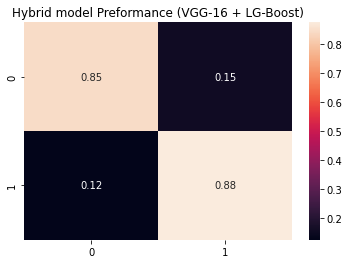

In [ ]:
# Confusion matrix based on LGBOOST
cm = confusion_matrix(y_test, lgb_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('Hybrid model Preformance (VGG-16 + LG-Boost)')

Text(0.5, 1.0, 'Incorrect Prediction Vs True Label of Hybrid Model (Vgg-16 + LG-Boost)')

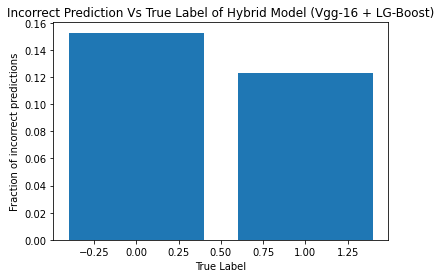

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.title('Incorrect Prediction Vs True Label of Hybrid Model (Vgg-16 + LG-Boost)')

# Coding of Gradient Boost Starts from here




In [ ]:
#  Gradient boosting classifier

from sklearn.ensemble import GradientBoostingClassifier

gbmodel =  GradientBoostingClassifier()

gbmodel.fit(X_train_features, y_train)
gb_pred = gbmodel.predict(X_test_features)

In [ ]:
print('Accuracy of hybrid model (VGG-16 + Gradient-BOOST): ', metrics.accuracy_score(y_test, gb_pred)*100)


Accuracy of hybrid model (VGG-16 + Gradient-BOOST):  85.45454545454545


In [ ]:
# Classification report of GradientBOOST
print('Classification report of Hybrid Model (Vgg16 + Gradient-Boost) ')
print(classification_report(y_test, gb_pred))

Classification report of Hybrid Model (Vgg16 + Gradient-Boost) 
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       360
         1.0       0.83      0.86      0.84       300

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.86      0.85      0.85       660



Text(0.5, 1.0, 'Hybrid model Preformance (VGG-16 + Gradient-Boost)')

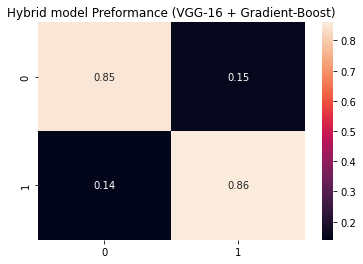

In [ ]:
# Confusion matrix based on GradientBOOST
cm = confusion_matrix(y_test, gb_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('Hybrid model Preformance (VGG-16 + Gradient-Boost)')

Text(0.5, 1.0, 'Incorrect Prediction Vs True Label of Hybrid Model (Vgg-16 + Gradient-Boost)')

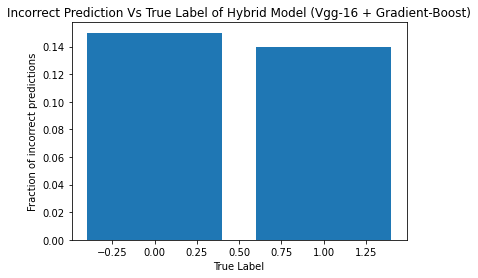

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.title('Incorrect Prediction Vs True Label of Hybrid Model (Vgg-16 + Gradient-Boost)')

In [ ]:
probs_xg = model.predict_proba(X_test_features)[:, 1]

In [ ]:
probs_lg = lgbmodel.predict_proba(X_test_features)[:, 1]

In [ ]:
probs_g = gbmodel.predict_proba(X_test_features)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

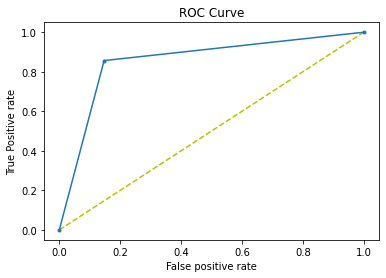

In [ ]:
updated_pred = gb_pred.ravel()
fpr, tpr, thresholds = roc_curve(y_test, updated_pred)
plt.figure(1)
plt.plot([0,1], [0,1], 'y--')
plt.plot(fpr, tpr, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.show()

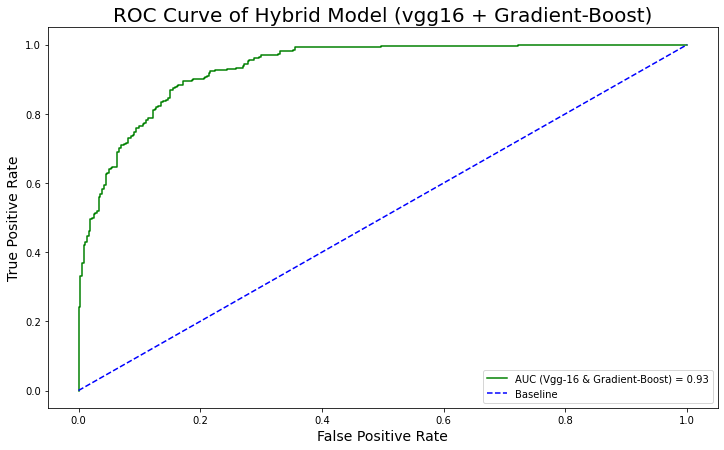

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# y_test_int = y_test.replace({'Good': 1, 'Bad': 0})
# auc_lr = roc_auc_score(y_test_int, probs_lr)
# fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_int, probs_lr)

auc_g = roc_auc_score(y_test, probs_g)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, probs_g)

# auc_lg = roc_auc_score(y_test, probs_lg)
# fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_lg)

# auc_xg = roc_auc_score(y_test, probs_xg)
# fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, probs_xg)

plt.figure(figsize=(12, 7))
# plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_dt, tpr_dt,color='green', label=f'AUC (Vgg-16 & Gradient-Boost) = {auc_g:.2f}')
# plt.plot(fpr_rf, tpr_rf, color =  'red', label=f'AUC (Vgg-16 & Lg-Boost) = {auc_lg:.2f}')
# plt.plot(fpr_xg, tpr_xg, label=f'AUC (Vgg-16 & XGBoost) = {auc_xg:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve of Hybrid Model (vgg16 + Gradient-Boost)', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

Shell based final automated system for detecting skin cancer

1/1 [==============================] - 1s 1s/step
[0]


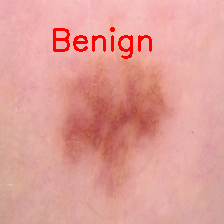

In [ ]:
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.utils as image
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import pickle

# Load the VGG16 model
# with open('/content/vgg16_model.pkl', 'rb') as n:
#     vmodel = pickle.load(n)
vmodel = VGG16(include_top = False,input_shape =(224,224,3))
for layers in (vmodel.layers):
    layers.trainable = False

image = Image.open('/content/23.jpg')
new_size = (224, 224)
resized_image = image.resize(new_size)

x = img_to_array(resized_image)
x = x/255
# Add an extra dimension to represent the batch size (1 in this case)
x = np.expand_dims(x, axis=0)


# Pass the input to the VGG16 model and get the output of the convolutional layers
feature_extractor = vmodel.predict(x)

# Flatten the output of the convolutional layers
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
with open('/content/hybrid_surya_model.pkl', 'rb') as f:
    pmodel = pickle.load(f)



prediction = pmodel.predict(features)
print(prediction)



# visually showing the image
font = cv2.FONT_HERSHEY_SIMPLEX
bottom_left_corner_of_text = (50,50)
font_scale = 1
font_color = (0, 0, 255) # red color
line_type = 2
img = np.array(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if prediction == 0:
  cv2.putText(img,'Benign', bottom_left_corner_of_text, font, font_scale, font_color, line_type)
else:
  cv2.putText(img,'malignant',bottom_left_corner_of_text, font, font_scale, font_color, line_type)

cv2_imshow(img)

In [ ]:
import pickle
from keras.applications.vgg16 import VGG16

model = VGG16(input_shape=(224,224, 3), include_top=False)


58889256/58889256 [==============================] - 0s 0us/step


In the below code I downloaded vgg 16  architecture for further *research*

In [ ]:
with open('vgg16_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('/content/hybrid_surya_model.pkl', 'rb') as f:
    pmodel = pickle.load(f)
cm = pmodel.predict
